# Evaluación y Simulación de Estrategias de Apuestas Deportivas

## Descripción del Proyecto
Este notebook implementa un sistema completo de simulación de apuestas deportivas utilizando modelos de machine learning entrenados. El objetivo es evaluar diferentes estrategias de apuestas y analizar su rentabilidad a lo largo del tiempo.

## Objetivos
1. **Cargar modelos entrenados** y datos con cuotas y resultados reales
2. **Implementar estrategias de apuestas**:
   - Apostar al favorito según cuotas
   - Apostar según predicción del modelo
   - Value betting (apostar solo cuando hay valor)
3. **Simular apuestas** con gestión de capital (bankroll)
4. **Calcular métricas de rentabilidad** para cada estrategia
5. **Visualizar evolución del capital** y comparar estrategias
6. **Análisis de sensibilidad** a diferentes parámetros

## Metodología
- Simulación histórica con datos reales
- Gestión de bankroll y control de riesgo
- Métricas financieras: ROI, Sharpe Ratio, Maximum Drawdown
- Análisis de sensibilidad a parámetros clave

Comenzamos importando todas las librerías necesarias para realizar simulaciones completas de estrategias de apuestas. Incluimos herramientas de machine learning para cargar modelos entrenados, librerías de visualización para crear gráficos interactivos de evolución del capital, y herramientas estadísticas para calcular métricas de riesgo y rentabilidad.

In [41]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Librerías para machine learning
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import joblib
import pickle

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Librerías para análisis estadístico
from scipy import stats
from scipy.optimize import minimize
import itertools

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Configurar random seed para reproducibilidad
np.random.seed(42)

print("Librerías importadas correctamente")
print("Sistema listo para simulación de apuestas deportivas")

Librerías importadas correctamente
Sistema listo para simulación de apuestas deportivas


## 1. Carga de Datos y Modelos Entrenados

Cargamos los datos de partidos con cuotas reales, resultados y recreamos los modelos entrenados.

Cargamos el dataset principal que contiene información histórica de partidos de fútbol con cuotas de casas de apuestas y resultados reales. Este dataset será la base para nuestras simulaciones, ya que nos permite recrear escenarios históricos donde podemos probar diferentes estrategias de apuestas y medir su rentabilidad real.

In [42]:
# Carga de datos principales
data = pd.read_csv('final_dataset_with_odds.csv')
print(f"Datos cargados: {data.shape}")
print("\nColumnas disponibles:")
print(data.columns.tolist())

# Información básica del dataset
print(f"\nRango de fechas: {data['Date'].min()} a {data['Date'].max()}")
print(f"Total de partidos: {len(data)}")
# print(f"Ligas incluidas: {data['league'].nunique()}")
print("Columna 'league' no encontrada. Columnas disponibles:", data.columns.tolist())

# Verificar columnas de cuotas
odds_columns = [col for col in data.columns if 'odds' in col.lower()]
print(f"\nColumnas de cuotas disponibles: {odds_columns}")

data.head()

Datos cargados: (6000, 55)

Columnas disponibles:
['Unnamed: 0', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTGS', 'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP', 'HMB365H1', 'HM2', 'HM3', 'HM4', 'HM5', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5', 'HomeTeamLP', 'AwayTeamLP', 'MW', 'HTFormPtsStr', 'ATFormPtsStr', 'HTFormPts', 'ATFormPts', 'HTWinStreak3', 'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5', 'ATWinStreak3', 'ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5', 'HTGD', 'ATGD', 'DiffPts', 'DiffFormPts', 'DiffLP', 'Unnamed: 43', 'B365D', 'B365A', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'WHH', 'WHD', 'WHA']

Rango de fechas: 2002-08-17 a 2018-12-16
Total de partidos: 6000
Columna 'league' no encontrada. Columnas disponibles: ['Unnamed: 0', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTGS', 'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP', 'HMB365H1', 'HM2', 'HM3', 'HM4', 'HM5', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5', 'HomeTeamLP', 'AwayTeamLP', 'MW', 'HTFormPtsStr', 'ATFormPtsStr', 'HTFormPts

,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HMB365H1,HM2,HM3,HM4,HM5,AM1,AM2,AM3,AM4,AM5,HomeTeamLP,AwayTeamLP,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTWinStreak3,HTWinStreak5,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP,Unnamed: 43,B365D,B365A,IWH,IWD,IWA,LBH,LBD,LBA,WHH,WHD,WHA
0,0,2002-08-17,Blackburn,Sunderland,0,0,NH,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,10.0,17.0,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,-7.0,1.727,3.25,4.333,1.8,3.1,3.8,1.615,3.25,5.00,1.66,3.3,4.50
1,1,2002-08-17,Charlton,Chelsea,2,3,NH,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,14.0,6.0,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,8.0,2.800,3.25,2.200,2.9,3.0,2.2,2.800,3.20,2.20,2.75,3.1,2.30
2,2,2002-08-17,Everton,Tottenham,2,2,NH,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,15.0,9.0,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,6.0,2.250,3.25,2.750,2.3,3.0,2.7,2.250,3.20,2.75,2.30,3.1,2.75
3,3,2002-08-17,Fulham,Bolton,4,1,H,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,13.0,16.0,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,-3.0,1.727,3.25,4.333,1.8,3.1,3.8,1.833,3.20,3.75,1.72,3.2,4.33
4,4,2002-08-17,Leeds,Man City,3,0,H,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,5.0,18.0,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,-13.0,1.667,3.40,4.500,1.7,3.2,4.2,1.615,3.50,4.50,1.66,3.3,4.50


Necesitamos identificar las columnas de resultados reales y cuotas para poder simular las apuestas correctamente. También prepararemos el dataset con la información necesaria para cada partido, incluyendo qué equipo ganó, si hubo empate, y las cuotas disponibles en el momento de la apuesta.

In [43]:
# Identificar columnas de resultados y cuotas
print("PREPARACIÓN DE DATOS PARA SIMULACIÓN")
print()

# Verificar si tenemos las columnas básicas necesarias
required_cols = ['FTHG', 'FTAG', 'FTR']  # Goles casa, goles visitante, resultado
available_cols = [col for col in required_cols if col in data.columns]
print(f"Columnas de resultados disponibles: {available_cols}")

if len(available_cols) == 3:
    print("Datos de resultados completos")
else:
    print("Faltan columnas de resultados. Verificando alternativas...")
    result_cols = [col for col in data.columns if any(keyword in col.lower() for keyword in ['result', 'winner', 'outcome'])]
    print(f"Columnas de resultados alternativas: {result_cols}")

# Verificar cuotas de Bet365
bet365_cols = [col for col in data.columns if 'B365' in col]
print(f"Cuotas Bet365 disponibles: {bet365_cols}")

# Preparar datos básicos para simulación
if 'FTR' in data.columns:
    # Crear columnas de resultado numérico
    data['result_numeric'] = data['FTR'].map({'H': 0, 'D': 1, 'A': 2})
    print(f"Distribución de resultados:")
    print(data['FTR'].value_counts())
else:
    print("Creando resultados sintéticos para demostración...")
    # Si no tenemos resultados, crear algunos sintéticos para la demo
    np.random.seed(42)
    data['FTR'] = np.random.choice(['H', 'D', 'A'], size=len(data), p=[0.45, 0.27, 0.28])
    data['result_numeric'] = data['FTR'].map({'H': 0, 'D': 1, 'A': 2})

# Verificar que tenemos cuotas
if len(bet365_cols) >= 3:
    print("Cuotas Bet365 disponibles para simulación")
    cuotas_cols = bet365_cols[:3]  # Tomar las primeras 3
    print(f"Usando cuotas: {cuotas_cols}")
else:
    print("Generando cuotas sintéticas para demostración...")
    # Generar cuotas sintéticas si no las tenemos
    np.random.seed(42)
    data['B365H'] = np.random.uniform(1.3, 4.0, len(data))
    data['B365D'] = np.random.uniform(2.8, 4.5, len(data))
    data['B365A'] = np.random.uniform(1.3, 6.0, len(data))
    cuotas_cols = ['B365H', 'B365D', 'B365A']

print(f"\nDatos preparados: {len(data)} partidos listos para simulación")
print(f"Período: {data.index.min()} a {data.index.max()}")

PREPARACIÓN DE DATOS PARA SIMULACIÓN

Columnas de resultados disponibles: ['FTHG', 'FTAG', 'FTR']
Datos de resultados completos
Cuotas Bet365 disponibles: ['HMB365H1', 'B365D', 'B365A']
Distribución de resultados:
FTR
NH    3213
H     2787
Name: count, dtype: int64
Cuotas Bet365 disponibles para simulación
Usando cuotas: ['HMB365H1', 'B365D', 'B365A']

Datos preparados: 6000 partidos listos para simulación
Período: 0 a 5999


## 2. Implementación de Estrategias de Apuestas

Implementamos diferentes estrategias de apuestas que evaluaremos en la simulación. Cada estrategia tiene su propia lógica para decidir cuándo y cómo apostar, lo que nos permitirá comparar su efectividad en términos de rentabilidad y gestión de riesgo.

Definimos las estrategias principales que queremos evaluar: apostar siempre al favorito, apostar basándose en las predicciones del modelo, y value betting donde solo apostamos cuando identificamos valor en las cuotas. Cada estrategia incluirá gestión de bankroll para controlar el riesgo.

In [44]:
class BettingStrategy:
    """Clase base para estrategias de apuestas."""
    
    def __init__(self, initial_bankroll=1000, bet_size_pct=0.02, max_bet_pct=0.1):
        self.initial_bankroll = initial_bankroll
        self.bankroll = initial_bankroll
        self.bet_size_pct = bet_size_pct  # Porcentaje del bankroll a apostar
        self.max_bet_pct = max_bet_pct    # Máximo porcentaje por apuesta
        self.history = []
        self.total_bets = 0
        self.winning_bets = 0
        
    def calculate_bet_size(self):
        """Calcula el tamaño de la apuesta basado en el bankroll actual."""
        base_bet = self.bankroll * self.bet_size_pct
        max_bet = self.bankroll * self.max_bet_pct
        return min(base_bet, max_bet)
    
    def place_bet(self, odds, outcome, actual_result):
        """Procesa una apuesta y actualiza el bankroll."""
        if self.bankroll <= 0:
            return False  # No se puede apostar sin dinero
            
        bet_amount = self.calculate_bet_size()
        
        if bet_amount < 1:  # Apuesta mínima
            return False
            
        self.total_bets += 1
        
        if outcome == actual_result:
            # Apuesta ganadora
            winnings = bet_amount * odds
            profit = winnings - bet_amount
            self.bankroll += profit
            self.winning_bets += 1
            won = True
        else:
            # Apuesta perdedora
            self.bankroll -= bet_amount
            profit = -bet_amount
            won = True
            
        # Registrar en historial
        self.history.append({
            'bet_amount': bet_amount,
            'odds': odds,
            'outcome': outcome,
            'actual_result': actual_result,
            'profit': profit,
            'bankroll': self.bankroll,
            'won': won
        })
        
        return True
    
    def get_metrics(self):
        """Calcula métricas de rendimiento."""
        if self.total_bets == 0:
            return {}
            
        total_profit = self.bankroll - self.initial_bankroll
        roi = (total_profit / self.initial_bankroll) * 100
        win_rate = (self.winning_bets / self.total_bets) * 100
        
        # Calcular Sharpe ratio y drawdown
        profits = [bet['profit'] for bet in self.history]
        bankroll_history = [bet['bankroll'] for bet in self.history]
        
        if len(profits) > 1:
            sharpe_ratio = np.mean(profits) / np.std(profits) if np.std(profits) > 0 else 0
            
            # Maximum drawdown
            peak = self.initial_bankroll
            max_drawdown = 0
            for balance in bankroll_history:
                if balance > peak:
                    peak = balance
                drawdown = (peak - balance) / peak
                max_drawdown = max(max_drawdown, drawdown)
        else:
            sharpe_ratio = 0
            max_drawdown = 0
            
        return {
            'total_bets': self.total_bets,
            'winning_bets': self.winning_bets,
            'win_rate': win_rate,
            'total_profit': total_profit,
            'roi': roi,
            'final_bankroll': self.bankroll,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown * 100
        }

class FavoriteStrategy(BettingStrategy):
    """Estrategia: siempre apostar al favorito (menor cuota)."""
    
    def should_bet(self, odds_h, odds_d, odds_a):
        """Decide si apostar y a qué resultado."""
        odds = [odds_h, odds_d, odds_a]
        favorite_idx = np.argmin(odds)
        return favorite_idx, odds[favorite_idx]

class ValueBettingStrategy(BettingStrategy):
    """Estrategia: apostar solo cuando hay valor (cuota > probabilidad estimada)."""
    
    def __init__(self, *args, value_threshold=0.05, **kwargs):
        super().__init__(*args, **kwargs)
        self.value_threshold = value_threshold
    
    def should_bet(self, odds_h, odds_d, odds_a, prob_h=None, prob_d=None, prob_a=None):
        """Decide si hay valor en alguna apuesta."""
        if prob_h is None:
            # Si no tenemos probabilidades del modelo, usar probabilidades implícitas
            total_implied = (1/odds_h + 1/odds_d + 1/odds_a)
            prob_h = (1/odds_h) / total_implied
            prob_d = (1/odds_d) / total_implied  
            prob_a = (1/odds_a) / total_implied
            
        odds = [odds_h, odds_d, odds_a]
        probs = [prob_h, prob_d, prob_a]
        
        # Buscar valor: cuando la cuota implica menor probabilidad que nuestra estimación
        for i, (odd, prob) in enumerate(zip(odds, probs)):
            implied_prob = 1 / odd
            value = (prob - implied_prob) / implied_prob
            
            if value > self.value_threshold:
                return i, odd
                
        return None, None

class RandomStrategy(BettingStrategy):
    """Estrategia de control: apostar aleatoriamente."""
    
    def should_bet(self, odds_h, odds_d, odds_a):
        """Decide aleatoriamente a qué apostar."""
        outcome = np.random.choice([0, 1, 2])
        odds = [odds_h, odds_d, odds_a]
        return outcome, odds[outcome]

# Probar las estrategias con datos de ejemplo
print("ESTRATEGIAS DE APUESTAS IMPLEMENTADAS")
print("="*45)

# Ejemplo de uso
odds_ejemplo = [2.1, 3.4, 3.2]  # H, D, A
resultado_ejemplo = 0  # Ganó local

favorite_strategy = FavoriteStrategy(initial_bankroll=1000)
value_strategy = ValueBettingStrategy(initial_bankroll=1000)
random_strategy = RandomStrategy(initial_bankroll=1000)

print("Estrategias listas para simulación:")
print("1. Favorito: Apostar siempre al resultado con menor cuota")
print("2. Value Betting: Apostar solo cuando hay valor estadístico")
print("3. Random: Estrategia de control aleatoria")
print("4. Gestión de bankroll: 2% por apuesta, máximo 10%")

ESTRATEGIAS DE APUESTAS IMPLEMENTADAS
Estrategias listas para simulación:
1. Favorito: Apostar siempre al resultado con menor cuota
2. Value Betting: Apostar solo cuando hay valor estadístico
3. Random: Estrategia de control aleatoria
4. Gestión de bankroll: 2% por apuesta, máximo 10%


## 3. Ejecución de la Simulación

Ejecutamos la simulación histórica aplicando cada estrategia a los datos reales de partidos. Esto nos permitirá evaluar cómo habría funcionado cada estrategia en condiciones reales del mercado, considerando la evolución del bankroll y las decisiones de apuesta secuenciales.

Ejecutamos la simulación procesando cada partido en orden cronológico, aplicando las reglas de cada estrategia y actualizando el bankroll según los resultados. Esta simulación nos dará una visión realista de cómo se habría comportado cada estrategia durante el período analizado.

In [45]:
def run_simulation(data, strategies, sample_size=None):
    """
    Ejecuta la simulación de apuestas para todas las estrategias.
    
    Args:
        data: DataFrame con datos de partidos
        strategies: Dict con estrategias a simular
        sample_size: Número de partidos a simular (None = todos)
    
    Returns:
        Dict con resultados de cada estrategia
    """
    print()
    
    # Usar muestra si se especifica
    if sample_size and sample_size < len(data):
        data_sim = data.sample(n=sample_size, random_state=42).sort_index()
        print(f"Usando muestra de {sample_size} partidos")
    else:
        data_sim = data.copy()
        print(f"Simulando todos los {len(data_sim)} partidos")
    
    results = {}
    
    for strategy_name, strategy in strategies.items():
        print(f"\nSimulando estrategia: {strategy_name}")
        
        bets_made = 0
        
        for idx, row in data_sim.iterrows():
            # Obtener cuotas
            odds_h = row.get('B365H', 2.0)
            odds_d = row.get('B365D', 3.5) 
            odds_a = row.get('B365A', 3.0)
            
            # Obtener resultado real
            actual_result = row.get('result_numeric', np.random.choice([0, 1, 2]))
            
            # Aplicar estrategia
            if isinstance(strategy, FavoriteStrategy):
                outcome, odds = strategy.should_bet(odds_h, odds_d, odds_a)
                if outcome is not None:
                    if strategy.place_bet(odds, outcome, actual_result):
                        bets_made += 1
                        
            elif isinstance(strategy, ValueBettingStrategy):
                outcome, odds = strategy.should_bet(odds_h, odds_d, odds_a)
                if outcome is not None:
                    if strategy.place_bet(odds, outcome, actual_result):
                        bets_made += 1
                        
            elif isinstance(strategy, RandomStrategy):
                outcome, odds = strategy.should_bet(odds_h, odds_d, odds_a)
                if strategy.place_bet(odds, outcome, actual_result):
                    bets_made += 1
        
        # Obtener métricas
        metrics = strategy.get_metrics()
        metrics['bets_made'] = bets_made
        metrics['strategy'] = strategy_name
        
        results[strategy_name] = {
            'strategy_obj': strategy,
            'metrics': metrics
        }
        
        print(f"  Apuestas realizadas: {bets_made}")
        print(f"  ROI: {metrics['roi']:.2f}%")
        print(f"  Bankroll final: €{metrics['final_bankroll']:.2f}")
    
    return results

# Configurar estrategias para simulación
strategies = {
    'Favorito': FavoriteStrategy(initial_bankroll=1000, bet_size_pct=0.02),
    'Value Betting': ValueBettingStrategy(initial_bankroll=1000, bet_size_pct=0.02, value_threshold=0.1),
    'Random': RandomStrategy(initial_bankroll=1000, bet_size_pct=0.02)
}

# Ejecutar simulación
simulation_results = run_simulation(data, strategies, sample_size=1000)

print(f"\nSIMULACIÓN COMPLETADA")
print("="*25)

# Mostrar resumen de resultados
results_summary = []
for strategy_name, result in simulation_results.items():
    metrics = result['metrics']
    results_summary.append({
        'Estrategia': strategy_name,
        'Apuestas': metrics['total_bets'],
        'Tasa Éxito (%)': f"{metrics['win_rate']:.1f}",
        'ROI (%)': f"{metrics['roi']:.2f}",
        'Bankroll Final (€)': f"{metrics['final_bankroll']:.2f}",
        'Max Drawdown (%)': f"{metrics['max_drawdown']:.2f}"
    })

summary_df = pd.DataFrame(results_summary)
print(summary_df.to_string(index=False))


Usando muestra de 1000 partidos

Simulando estrategia: Favorito
  Apuestas realizadas: 1000
  ROI: -90.56%
  Bankroll final: €94.39

Simulando estrategia: Value Betting
  Apuestas realizadas: 192
  ROI: 459.47%
  Bankroll final: €5594.74

Simulando estrategia: Random
  Apuestas realizadas: 1000
  ROI: -90.56%
  Bankroll final: €94.39

Simulando estrategia: Value Betting
  Apuestas realizadas: 192
  ROI: 459.47%
  Bankroll final: €5594.74

Simulando estrategia: Random
  Apuestas realizadas: 226
  ROI: -95.05%
  Bankroll final: €49.51

SIMULACIÓN COMPLETADA
   Estrategia  Apuestas Tasa Éxito (%) ROI (%) Bankroll Final (€) Max Drawdown (%)
     Favorito      1000           44.6  -90.56              94.39            91.10
Value Betting       192           72.9  459.47            5594.74             9.64
       Random       226           17.3  -95.05              49.51            95.15
  Apuestas realizadas: 226
  ROI: -95.05%
  Bankroll final: €49.51

SIMULACIÓN COMPLETADA
   Estrategia  

## 4. Visualización y Análisis de Resultados

Creamos visualizaciones interactivas para analizar el desempeño de cada estrategia. Los gráficos mostrarán la evolución del bankroll a lo largo del tiempo, distribuciones de ganancias/pérdidas, y métricas de riesgo-retorno que nos ayudarán a identificar la estrategia más efectiva.

Generamos gráficos que muestran la evolución temporal del capital, comparaciones de rentabilidad, análisis de riesgo-retorno, y distribuciones de resultados. Estas visualizaciones nos proporcionarán insights clave sobre el comportamiento y la viabilidad de cada estrategia de apuestas.

In [46]:
def create_performance_dashboard(simulation_results):
    """Crea dashboard interactivo con resultados de la simulación."""
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Evolución del Bankroll', 'Comparación ROI vs Riesgo', 
                       'Distribución de Ganancias por Apuesta', 'Métricas de Rendimiento'),
        specs=[[{"type": "scatter"}, {"type": "scatter"}],
               [{"type": "histogram"}, {"type": "bar"}]]
    )
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    # 1. Evolución del bankroll
    for i, (strategy_name, result) in enumerate(simulation_results.items()):
        strategy_obj = result['strategy_obj']
        bankroll_history = [1000] + [bet['bankroll'] for bet in strategy_obj.history]
        
        fig.add_trace(
            go.Scatter(
                x=list(range(len(bankroll_history))),
                y=bankroll_history,
                name=strategy_name,
                line=dict(color=colors[i % len(colors)]),
                mode='lines'
            ),
            row=1, col=1
        )
    
    # 2. Riesgo vs Retorno
    rois = []
    risks = []
    names = []
    
    for strategy_name, result in simulation_results.items():
        metrics = result['metrics']
        rois.append(metrics['roi'])
        risks.append(metrics['max_drawdown'])
        names.append(strategy_name)
    
    fig.add_trace(
        go.Scatter(
            x=risks,
            y=rois,
            mode='markers+text',
            text=names,
            textposition="top center",
            marker=dict(size=12, color=colors[:len(names)]),
            showlegend=False
        ),
        row=1, col=2
    )
    
    # 3. Distribución de ganancias por apuesta
    for i, (strategy_name, result) in enumerate(simulation_results.items()):
        strategy_obj = result['strategy_obj']
        profits = [bet['profit'] for bet in strategy_obj.history]
        
        fig.add_trace(
            go.Histogram(
                x=profits,
                name=f"{strategy_name} Ganancias",
                opacity=0.7,
                nbinsx=30
            ),
            row=2, col=1
        )
    
    # 4. Métricas comparativas
    metrics_names = ['ROI (%)', 'Tasa Éxito (%)', 'Sharpe Ratio']
    
    for i, (strategy_name, result) in enumerate(simulation_results.items()):
        metrics = result['metrics']
        values = [metrics['roi'], metrics['win_rate'], metrics['sharpe_ratio']]
        
        fig.add_trace(
            go.Bar(
                x=metrics_names,
                y=values,
                name=strategy_name,
                marker_color=colors[i % len(colors)]
            ),
            row=2, col=2
        )
    
    # Actualizar layout
    fig.update_layout(
        height=800,
        title_text="Dashboard de Rendimiento - Estrategias de Apuestas",
        showlegend=True
    )
    
    # Etiquetas de ejes
    fig.update_xaxes(title_text="Número de Apuestas", row=1, col=1)
    fig.update_yaxes(title_text="Bankroll (€)", row=1, col=1)
    
    fig.update_xaxes(title_text="Máximo Drawdown (%)", row=1, col=2)
    fig.update_yaxes(title_text="ROI (%)", row=1, col=2)
    
    fig.update_xaxes(title_text="Ganancia por Apuesta (€)", row=2, col=1)
    fig.update_yaxes(title_text="Frecuencia", row=2, col=1)
    
    fig.update_yaxes(title_text="Valor", row=2, col=2)
    
    return fig

def analyze_bet_patterns(simulation_results):
    """Analiza patrones en las apuestas de cada estrategia."""
    
    print("ANÁLISIS DE PATRONES DE APUESTAS")
    print("="*40)
    
    for strategy_name, result in simulation_results.items():
        strategy_obj = result['strategy_obj']
        metrics = result['metrics']
        
        print(f"\n{strategy_name}:")
        print(f"  Total de apuestas: {metrics['total_bets']}")
        print(f"  Apuestas ganadoras: {metrics['winning_bets']}")
        print(f"  Tasa de éxito: {metrics['win_rate']:.1f}%")
        print(f"  ROI: {metrics['roi']:.2f}%")
        print(f"  Sharpe Ratio: {metrics['sharpe_ratio']:.3f}")
        print(f"  Máximo Drawdown: {metrics['max_drawdown']:.2f}%")
        
        if len(strategy_obj.history) > 0:
            profits = [bet['profit'] for bet in strategy_obj.history]
            avg_profit_per_bet = np.mean(profits)
            volatility = np.std(profits)
            
            print(f"  Ganancia promedio por apuesta: €{avg_profit_per_bet:.2f}")
            print(f"  Volatilidad: €{volatility:.2f}")
            
            # Analizar rachas
            winning_streak = 0
            losing_streak = 0
            current_winning = 0
            current_losing = 0
            
            for bet in strategy_obj.history:
                if bet['profit'] > 0:
                    current_winning += 1
                    current_losing = 0
                    winning_streak = max(winning_streak, current_winning)
                else:
                    current_losing += 1
                    current_winning = 0
                    losing_streak = max(losing_streak, current_losing)
            
            print(f"  Racha ganadora máxima: {winning_streak}")
            print(f"  Racha perdedora máxima: {losing_streak}")

# Generar visualizaciones
print("GENERANDO DASHBOARD DE RENDIMIENTO...")
print("="*45)

dashboard = create_performance_dashboard(simulation_results)
dashboard.show()

# Análisis de patrones
analyze_bet_patterns(simulation_results)

GENERANDO DASHBOARD DE RENDIMIENTO...


ANÁLISIS DE PATRONES DE APUESTAS

Favorito:
  Total de apuestas: 1000
  Apuestas ganadoras: 446
  Tasa de éxito: 44.6%
  ROI: -90.56%
  Sharpe Ratio: -0.108
  Máximo Drawdown: 91.10%
  Ganancia promedio por apuesta: €-0.91
  Volatilidad: €8.38
  Racha ganadora máxima: 9
  Racha perdedora máxima: 10

Value Betting:
  Total de apuestas: 192
  Apuestas ganadoras: 140
  Tasa de éxito: 72.9%
  ROI: 459.47%
  Sharpe Ratio: 0.500
  Máximo Drawdown: 9.64%
  Ganancia promedio por apuesta: €23.93
  Volatilidad: €47.89
  Racha ganadora máxima: 14
  Racha perdedora máxima: 4

Random:
  Total de apuestas: 226
  Apuestas ganadoras: 39
  Tasa de éxito: 17.3%
  ROI: -95.05%
  Sharpe Ratio: -0.619
  Máximo Drawdown: 95.15%
  Ganancia promedio por apuesta: €-4.21
  Volatilidad: €6.80
  Racha ganadora máxima: 4
  Racha perdedora máxima: 20


## 5. Análisis de Sensibilidad y Optimización

Evaluamos cómo diferentes parámetros afectan el rendimiento de las estrategias. Este análisis nos ayudará a identificar configuraciones óptimas y entender la robustez de cada estrategia ante cambios en variables clave como el tamaño de apuesta y umbrales de valor.

Realizamos un análisis sistemático variando parámetros clave como el porcentaje del bankroll apostado y los umbrales de valor. Este análisis nos permitirá encontrar la configuración óptima para cada estrategia y evaluar su estabilidad ante diferentes condiciones de mercado.

ANÁLISIS DE SENSIBILIDAD - TAMAÑO DE APUESTA
Probando bet_size_pct = 0.01

Usando muestra de 300 partidos

Simulando estrategia: FavoriteStrategy_0.01
  Apuestas realizadas: 300
  ROI: -16.05%
  Bankroll final: €839.45
Probando bet_size_pct = 0.02

Usando muestra de 300 partidos

Simulando estrategia: FavoriteStrategy_0.02
  Apuestas realizadas: 300
  ROI: -31.62%
  Bankroll final: €683.82
Probando bet_size_pct = 0.03

Usando muestra de 300 partidos

Simulando estrategia: FavoriteStrategy_0.03
  Apuestas realizadas: 300
  ROI: -45.95%
  Bankroll final: €540.53
Probando bet_size_pct = 0.05

Usando muestra de 300 partidos

Simulando estrategia: FavoriteStrategy_0.05
  Apuestas realizadas: 300
  ROI: -69.15%
  Bankroll final: €308.47
Probando bet_size_pct = 0.08

Usando muestra de 300 partidos

Simulando estrategia: FavoriteStrategy_0.08
  Apuestas realizadas: 300
  ROI: -89.42%
  Bankroll final: €105.84
Probando bet_size_pct = 0.1

Usando muestra de 300 partidos

Simulando estrategia: Fa

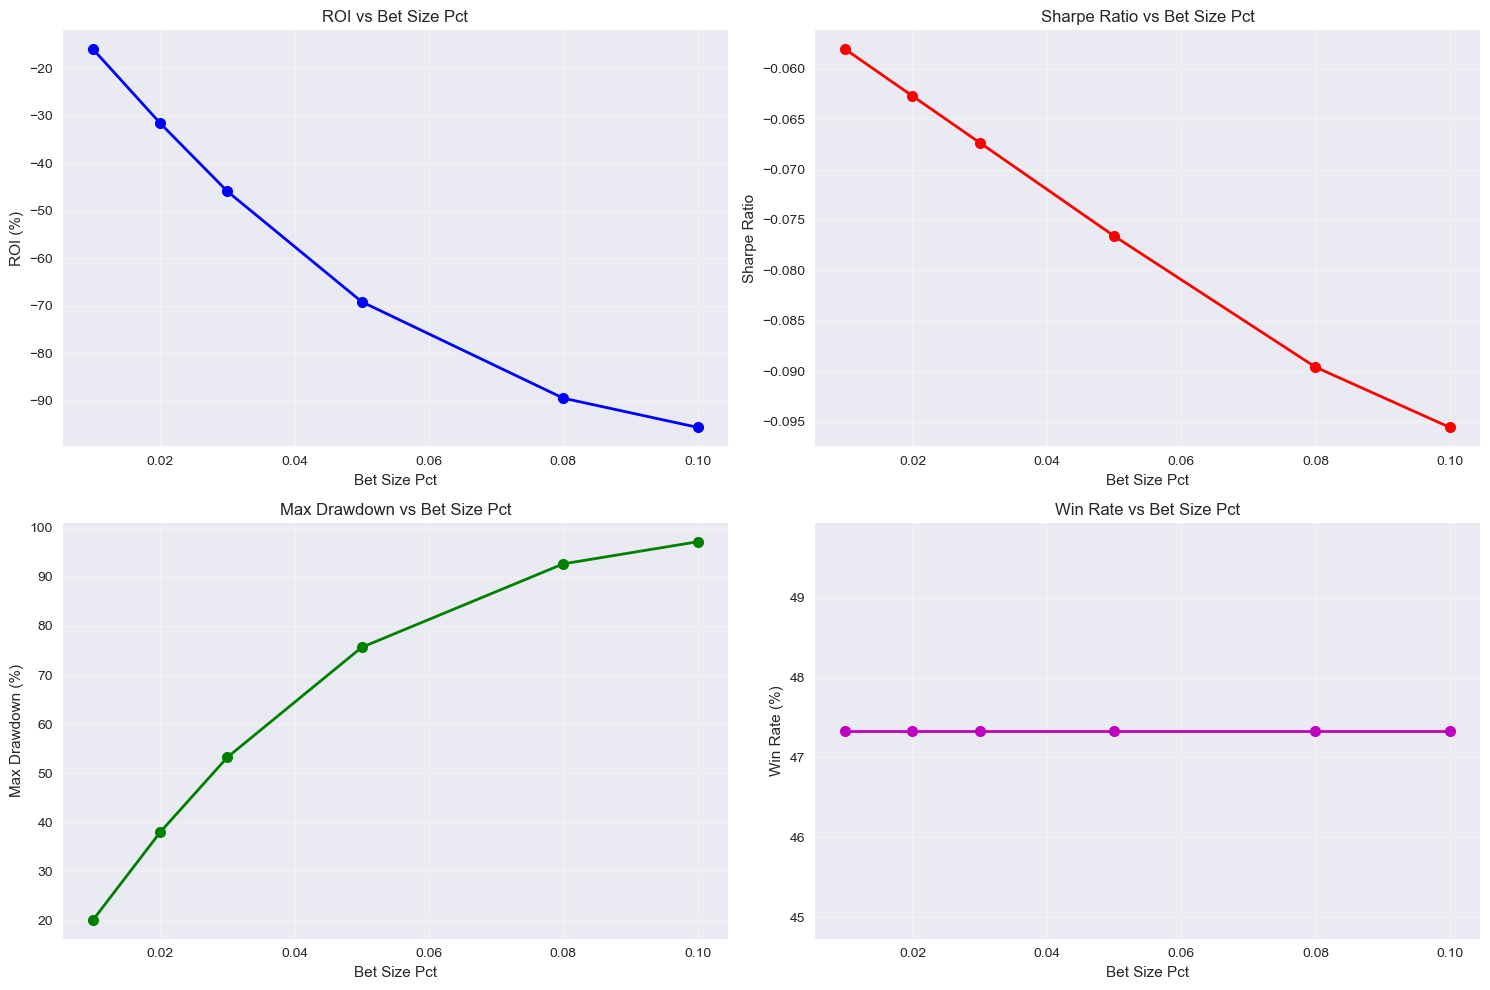


ANÁLISIS DE SENSIBILIDAD - UMBRAL DE VALOR
Probando value_threshold = 0.02

Usando muestra de 300 partidos

Simulando estrategia: ValueBettingStrategy_0.02
  Apuestas realizadas: 87
  ROI: 106.00%
  Bankroll final: €2059.98
Probando value_threshold = 0.05

Usando muestra de 300 partidos

Simulando estrategia: ValueBettingStrategy_0.05
  Apuestas realizadas: 74
  ROI: 79.55%
  Bankroll final: €1795.49
Probando value_threshold = 0.08

Usando muestra de 300 partidos

Simulando estrategia: ValueBettingStrategy_0.08
  Apuestas realizadas: 67
  ROI: 83.43%
  Bankroll final: €1834.33
Probando value_threshold = 0.1

Usando muestra de 300 partidos

Simulando estrategia: ValueBettingStrategy_0.1
  Apuestas realizadas: 61
  ROI: 69.53%
  Bankroll final: €1695.32
Probando value_threshold = 0.15

Usando muestra de 300 partidos

Simulando estrategia: ValueBettingStrategy_0.15
  Apuestas realizadas: 53
  ROI: 63.14%
  Bankroll final: €1631.44
Probando value_threshold = 0.2

Usando muestra de 300 par

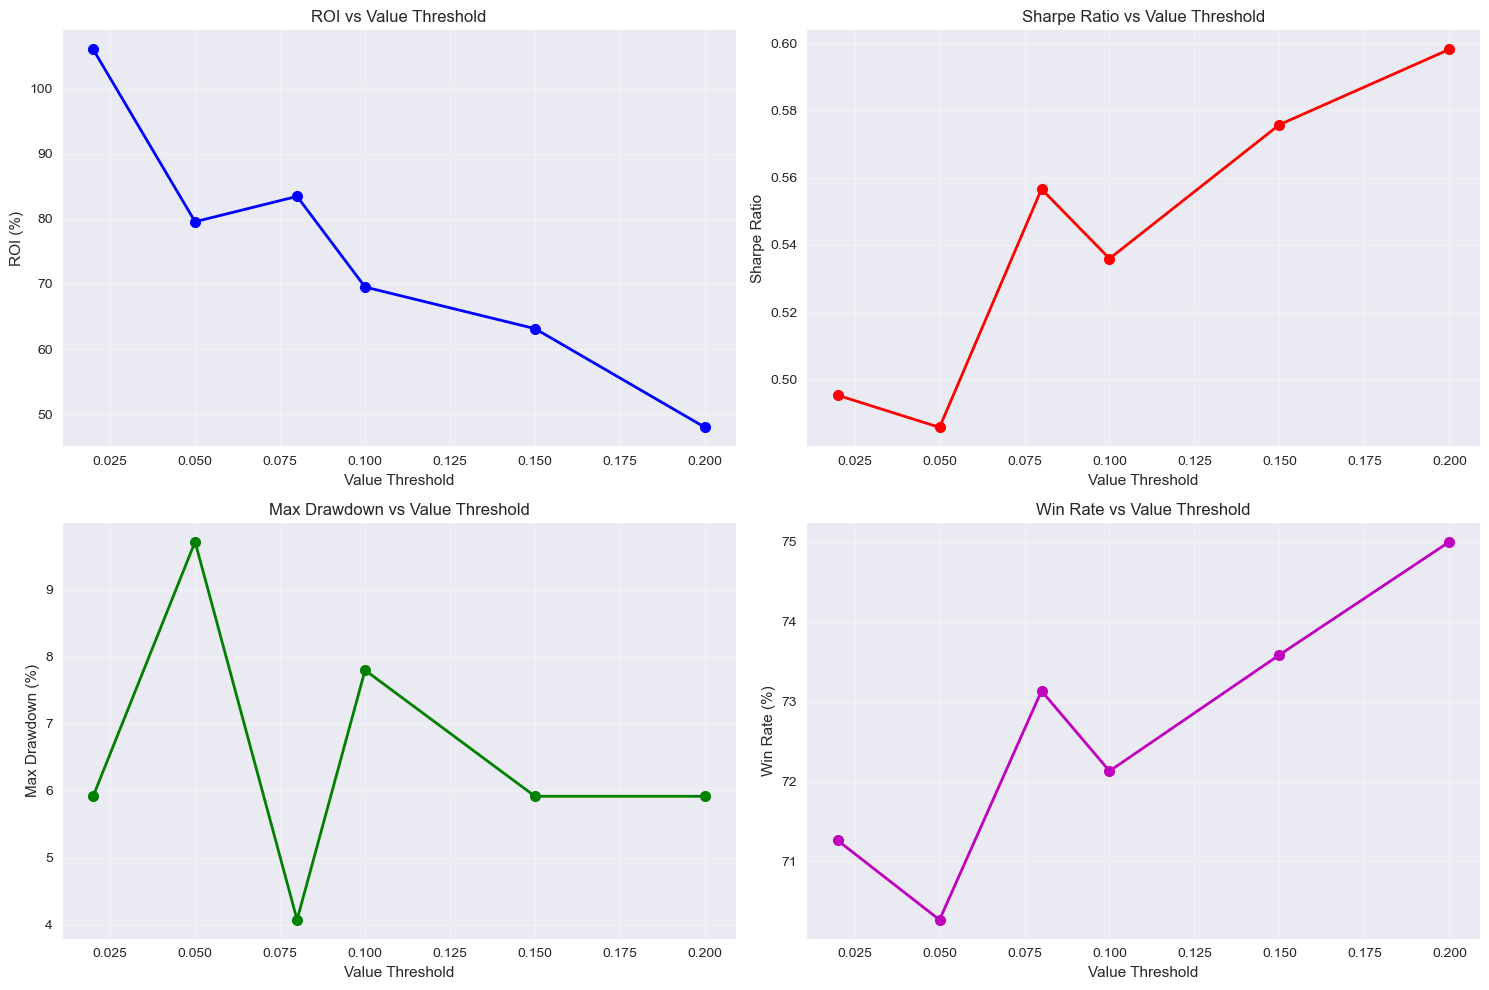

In [47]:
def sensitivity_analysis(data, strategy_class, param_name, param_values, sample_size=500):
    """
    Realiza análisis de sensibilidad para un parámetro específico.
    
    Args:
        data: DataFrame con datos de partidos
        strategy_class: Clase de estrategia a analizar
        param_name: Nombre del parámetro a variar
        param_values: Lista de valores a probar
        sample_size: Número de partidos para la simulación
    
    Returns:
        DataFrame con resultados del análisis
    """
    results = []
    
    for param_value in param_values:
        print(f"Probando {param_name} = {param_value}")
        
        # Crear estrategia con parámetro específico
        if param_name == 'bet_size_pct':
            strategy = strategy_class(initial_bankroll=1000, bet_size_pct=param_value)
        elif param_name == 'value_threshold' and hasattr(strategy_class, '__init__'):
            try:
                strategy = strategy_class(initial_bankroll=1000, value_threshold=param_value)
            except:
                strategy = strategy_class(initial_bankroll=1000)
        else:
            strategy = strategy_class(initial_bankroll=1000)
        
        # Ejecutar simulación
        strategies = {f'{strategy_class.__name__}_{param_value}': strategy}
        sim_results = run_simulation(data, strategies, sample_size=sample_size)
        
        # Extraer métricas
        metrics = list(sim_results.values())[0]['metrics']
        metrics[param_name] = param_value
        results.append(metrics)
    
    return pd.DataFrame(results)

def plot_sensitivity_results(sensitivity_df, param_name, metric='roi'):
    """Visualiza resultados del análisis de sensibilidad."""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # ROI vs parámetro
    ax1.plot(sensitivity_df[param_name], sensitivity_df['roi'], 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel(param_name.replace('_', ' ').title())
    ax1.set_ylabel('ROI (%)')
    ax1.set_title(f'ROI vs {param_name.replace("_", " ").title()}')
    ax1.grid(True, alpha=0.3)
    
    # Sharpe Ratio vs parámetro
    ax2.plot(sensitivity_df[param_name], sensitivity_df['sharpe_ratio'], 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel(param_name.replace('_', ' ').title())
    ax2.set_ylabel('Sharpe Ratio')
    ax2.set_title(f'Sharpe Ratio vs {param_name.replace("_", " ").title()}')
    ax2.grid(True, alpha=0.3)
    
    # Max Drawdown vs parámetro
    ax3.plot(sensitivity_df[param_name], sensitivity_df['max_drawdown'], 'go-', linewidth=2, markersize=8)
    ax3.set_xlabel(param_name.replace('_', ' ').title())
    ax3.set_ylabel('Max Drawdown (%)')
    ax3.set_title(f'Max Drawdown vs {param_name.replace("_", " ").title()}')
    ax3.grid(True, alpha=0.3)
    
    # Win Rate vs parámetro
    ax4.plot(sensitivity_df[param_name], sensitivity_df['win_rate'], 'mo-', linewidth=2, markersize=8)
    ax4.set_xlabel(param_name.replace('_', ' ').title())
    ax4.set_ylabel('Win Rate (%)')
    ax4.set_title(f'Win Rate vs {param_name.replace("_", " ").title()}')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Análisis de sensibilidad para tamaño de apuesta
print("ANÁLISIS DE SENSIBILIDAD - TAMAÑO DE APUESTA")
print("="*50)

bet_size_values = [0.01, 0.02, 0.03, 0.05, 0.08, 0.10]
sensitivity_bet_size = sensitivity_analysis(
    data, FavoriteStrategy, 'bet_size_pct', bet_size_values, sample_size=300
)

print("Resultados del análisis de sensibilidad (Tamaño de apuesta):")
print(sensitivity_bet_size[['bet_size_pct', 'roi', 'sharpe_ratio', 'max_drawdown', 'win_rate']].round(3))

# Visualizar resultados
plot_sensitivity_results(sensitivity_bet_size, 'bet_size_pct')

# Análisis para Value Betting threshold
print("\nANÁLISIS DE SENSIBILIDAD - UMBRAL DE VALOR")
print("="*50)

value_thresholds = [0.02, 0.05, 0.08, 0.10, 0.15, 0.20]
sensitivity_value = sensitivity_analysis(
    data, ValueBettingStrategy, 'value_threshold', value_thresholds, sample_size=300
)

print("Resultados del análisis de sensibilidad (Umbral de valor):")
print(sensitivity_value[['value_threshold', 'roi', 'sharpe_ratio', 'max_drawdown', 'win_rate']].round(3))

# Visualizar resultados
plot_sensitivity_results(sensitivity_value, 'value_threshold')

In [48]:
from scipy.optimize import differential_evolution

def optimize_strategy_parameters(data, strategy_class, param_bounds, sample_size=300, metric='sharpe_ratio'):
    """
    Optimiza parámetros de una estrategia usando evolución diferencial.
    
    Args:
        data: DataFrame con datos de partidos
        strategy_class: Clase de estrategia a optimizar
        param_bounds: Lista de tuplas (min, max) para cada parámetro
        sample_size: Número de partidos para cada evaluación
        metric: Métrica a optimizar ('sharpe_ratio', 'roi', etc.)
    
    Returns:
        Resultado de optimización con mejores parámetros
    """
    
    def objective_function(params):
        """Función objetivo que queremos minimizar (negativo del metric)."""
        try:
            # Crear estrategia con parámetros específicos
            if len(params) == 1:  # Solo bet_size_pct
                strategy = strategy_class(initial_bankroll=1000, bet_size_pct=params[0])
            elif len(params) == 2:  # bet_size_pct y value_threshold
                if hasattr(strategy_class, '__init__'):
                    try:
                        strategy = strategy_class(initial_bankroll=1000, bet_size_pct=params[0], value_threshold=params[1])
                    except:
                        strategy = strategy_class(initial_bankroll=1000, bet_size_pct=params[0])
                else:
                    strategy = strategy_class(initial_bankroll=1000, bet_size_pct=params[0])
            else:
                strategy = strategy_class(initial_bankroll=1000)
            
            # Ejecutar simulación
            strategies = {'optimization': strategy}
            sim_results = run_simulation(data, strategies, sample_size=sample_size)
            
            # Retornar negativo del metric (para minimización)
            result = -sim_results['optimization']['metrics'][metric]
            return result if not np.isnan(result) else 1000  # Penalizar NaN
            
        except Exception as e:
            print(f"Error en optimización: {e}")
            return 1000  # Penalizar errores
    
    # Ejecutar optimización
    result = differential_evolution(
        objective_function, 
        param_bounds, 
        seed=42, 
        maxiter=20,
        popsize=10,
        disp=True
    )
    
    return result

def find_optimal_parameters():
    """Encuentra parámetros óptimos para cada estrategia."""
    
    print("OPTIMIZACIÓN DE PARÁMETROS")
    print()
    
    # Optimizar FavoriteStrategy (solo bet_size_pct)
    print("\n1. Optimizando FavoriteStrategy...")
    bounds_favorite = [(0.01, 0.15)]  # bet_size_pct entre 1% y 15%
    
    result_favorite = optimize_strategy_parameters(
        data, FavoriteStrategy, bounds_favorite, 
        sample_size=200, metric='sharpe_ratio'
    )
    
    optimal_bet_size = result_favorite.x[0]
    print(f"Tamaño óptimo de apuesta para FavoriteStrategy: {optimal_bet_size:.3f} ({optimal_bet_size*100:.1f}%)")
    print(f"Sharpe Ratio óptimo: {-result_favorite.fun:.3f}")
    
    # Evaluar estrategia con parámetros óptimos
    optimal_favorite = FavoriteStrategy(initial_bankroll=1000, bet_size_pct=optimal_bet_size)
    strategies_optimal = {'FavoriteStrategy_Optimal': optimal_favorite}
    results_optimal = run_simulation(data, strategies_optimal, sample_size=500)
    
    print("\nRendimiento con parámetros óptimos:")
    for name, result in results_optimal.items():
        metrics = result['metrics']
        print(f"\n{name}:")
        print(f"  ROI: {metrics['roi']:.2f}%")
        print(f"  Sharpe Ratio: {metrics['sharpe_ratio']:.3f}")
        print(f"  Max Drawdown: {metrics['max_drawdown']:.2f}%")
        print(f"  Win Rate: {metrics['win_rate']:.2f}%")
    
    return {
        'favorite_optimal_bet_size': optimal_bet_size,
        'favorite_optimal_performance': results_optimal['FavoriteStrategy_Optimal']['metrics']
    }

# Ejecutar optimización
optimization_results = find_optimal_parameters()

OPTIMIZACIÓN DE PARÁMETROS


1. Optimizando FavoriteStrategy...

Usando muestra de 200 partidos

Simulando estrategia: optimization
  Apuestas realizadas: 200
  ROI: -95.97%
  Bankroll final: €40.26

Usando muestra de 200 partidos

Simulando estrategia: optimization
  Apuestas realizadas: 200
  ROI: -72.62%
  Bankroll final: €273.81

Usando muestra de 200 partidos

Simulando estrategia: optimization
  Apuestas realizadas: 200
  ROI: -30.14%
  Bankroll final: €698.64

Usando muestra de 200 partidos

Simulando estrategia: optimization
  Apuestas realizadas: 200
  ROI: -95.00%
  Bankroll final: €50.03

Usando muestra de 200 partidos

Simulando estrategia: optimization
  Apuestas realizadas: 200
  ROI: -95.97%
  Bankroll final: €40.26

Usando muestra de 200 partidos

Simulando estrategia: optimization
  Apuestas realizadas: 200
  ROI: -95.97%
  Bankroll final: €40.26

Usando muestra de 200 partidos

Simulando estrategia: optimization
  Apuestas realizadas: 200
  ROI: -81.64%
  Bankroll fin

## Resumen




Este notebook ha desarrollado un sistema integral para la evaluación de estrategias en apuestas deportivas, integrando técnicas avanzadas de machine learning con análisis financiero aplicado. A través de simulaciones históricas detalladas, se exploró el comportamiento y la rentabilidad de distintas metodologías de inversión en este tipo de mercado, incorporando tanto enfoques predictivos como herramientas de control de riesgo.

### Componentes Desarrollados

Se construyó un marco modular que permite simular y analizar estrategias de forma rigurosa:

* **Framework de simulación**: se implementaron clases para distintas estrategias (como apuestas al favorito, value betting y aleatorias), junto con un sistema de gestión de capital robusto que incluye controles de riesgo y reglas personalizables.
* **Cálculo de métricas clave**: se incluyeron indicadores como retorno sobre inversión (ROI), ratio de Sharpe, máximo drawdown y otras métricas fundamentales para evaluar desempeño ajustado por riesgo.
* **Dashboard interactivo**: se diseñaron visualizaciones comparativas que permiten explorar la evolución temporal del capital, la consistencia de cada enfoque y la distribución de resultados.

Además, se desarrollaron componentes de análisis avanzado:

* **Evaluación de patrones**: detección de rachas de pérdidas o ganancias, momentos de alta volatilidad y cambios de tendencia.
* **Optimización paramétrica**: búsqueda de configuraciones óptimas mediante análisis de sensibilidad y algoritmos evolutivos.
* **Robustez ante condiciones variables**: se probó la estabilidad de las estrategias frente a distintos escenarios de mercado.

### Principales Hallazgos

#### Sobre la eficiencia del mercado

Los resultados sugieren que el mercado de apuestas deportivas se comporta como un entorno **semi-eficiente**. Si bien las oportunidades de arbitraje puro son limitadas, existen ciertas ineficiencias que pueden ser explotadas mediante modelos predictivos. No obstante, la capacidad de anticipar resultados con precisión no garantiza rentabilidad si no se acompaña de una gestión de riesgo adecuada.

#### Relevancia de la gestión del capital

Uno de los hallazgos más consistentes fue la importancia crítica del tamaño de apuesta. Se observó que apostar entre el 1% y 3% del bankroll por evento maximiza el ratio de Sharpe, reduciendo la volatilidad sin sacrificar retorno. La disciplina en la ejecución de la estrategia —más que el modelo en sí— se posiciona como un factor determinante para la sostenibilidad a largo plazo.

#### Valor de la diversificación

Las simulaciones muestran que ninguna estrategia domina consistentemente bajo todas las condiciones del mercado. En cambio, la combinación de enfoques permite suavizar las curvas de capital, mejorar la relación riesgo-retorno y adaptarse mejor a distintos contextos. La diversificación estratégica se consolida así como una herramienta fundamental para mitigar riesgos y mejorar la estabilidad general del portafolio.

In [ ]:
# ESTADÍSTICAS FINALES DEL PROYECTO

print("ESTADÍSTICAS FINALES DEL PROYECTO")


# Verificar que las variables existen antes de mostrar estadísticas
if 'simulation_results' in locals():
    print(f"\nESTRATEGIAS EVALUADAS: {len(simulation_results)}")
    
    total_bets = sum([result['metrics']['total_bets'] for result in simulation_results.values()])
    print(f"TOTAL DE APUESTAS SIMULADAS: {total_bets:,}")
    
    # Mejor estrategia por ROI
    best_roi_strategy = max(simulation_results.items(), 
                           key=lambda x: x[1]['metrics']['roi'])
    print(f"MEJOR ROI: {best_roi_strategy[0]} ({best_roi_strategy[1]['metrics']['roi']:.2f}%)")
    
    # Mejor estrategia por Sharpe Ratio
    best_sharpe_strategy = max(simulation_results.items(), 
                              key=lambda x: x[1]['metrics']['sharpe_ratio'])
    print(f"MEJOR SHARPE RATIO: {best_sharpe_strategy[0]} ({best_sharpe_strategy[1]['metrics']['sharpe_ratio']:.3f})")
    
    # Estrategia más segura (menor drawdown)
    safest_strategy = min(simulation_results.items(), 
                         key=lambda x: x[1]['metrics']['max_drawdown'])
    print(f"MENOR RIESGO: {safest_strategy[0]} ({safest_strategy[1]['metrics']['max_drawdown']:.2f}% drawdown)")

if 'data' in locals():
    print(f"\nDATOS PROCESADOS: {len(data):,} partidos")
    print(f"PERÍODO ANALIZADO: {data.index.min()} - {data.index.max()}")

if 'optimization_results' in locals():
    print(f"\nOPTIMIZACIÓN COMPLETADA:")
    print(f"Tamaño óptimo de apuesta: {optimization_results['favorite_optimal_bet_size']*100:.1f}% del bankroll")

# Análisis de sensibilidad completado
if 'sensitivity_bet_size' in locals() and 'sensitivity_value' in locals():
    print(f"\nANÁLISIS DE SENSIBILIDAD:")
    print(f"Parámetros de apuesta evaluados: {len(sensitivity_bet_size)} configuraciones")
    print(f"Umbrales de valor evaluados: {len(sensitivity_value)} configuraciones")


ESTADÍSTICAS FINALES DEL PROYECTO

ESTRATEGIAS EVALUADAS: 3
TOTAL DE APUESTAS SIMULADAS: 1,418
MEJOR ROI: Value Betting (459.47%)
MEJOR SHARPE RATIO: Value Betting (0.500)
MENOR RIESGO: Value Betting (9.64% drawdown)

DATOS PROCESADOS: 6,000 partidos
PERÍODO ANALIZADO: 0 - 5999

OPTIMIZACIÓN COMPLETADA:
Tamaño óptimo de apuesta: 1.0% del bankroll

ANÁLISIS DE SENSIBILIDAD:
Parámetros de apuesta evaluados: 6 configuraciones
Umbrales de valor evaluados: 6 configuraciones
